In [99]:
from __future__ import print_function
import numpy as np
import mxnet as mx
import random
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

### Set a fixed random seed for reproducibility

In [100]:
mx.random.seed(1)

### Set context

In [101]:
# ctx = mx.gpu()
ctx = mx.cpu()

### Load dataset

Moves the channel axis of the images to the beginning ((28, 28, 1) -> (1, 28, 28)), casts them to float32 and rescales them from [0, 255] to [0, 1]

In [116]:
batch_size = 64
def transform(data, label):
    return nd.transpose(data.astype(np.float32), (2,0,1))/255, label.astype(np.float32)
train_data = gluon.data.DataLoader(gluon.data.vision.MNIST(train=True, transform=transform),
                                      batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.vision.MNIST(train=False, transform=transform),
                                     batch_size, shuffle=False)

### Define Neural Network

In [103]:
num_fc = 512
num_outputs = 10
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Conv2D(channels=50, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(num_fc, activation="relu"))
    net.add(gluon.nn.Dense(num_outputs))

### Parameters initialization

In [105]:
net.initialize(mx.init.Xavier(), ctx=ctx)

### Define loss function - Softmax cross-entropy Loss

In [106]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

### Define optimizer

In [107]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': .1})

### Define function to calculate accuracy

In [108]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

### Training loop

In [109]:
epochs = 15

for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])

        ##########################
        #  Keep a moving average of the losses
        ##########################
        smoothing_constant = .01
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                       else (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss)

    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, moving_loss, train_accuracy, test_accuracy))

Epoch 0. Loss: 0.0715804727016, Train_acc 0.982616666667, Test_acc 0.9834
Epoch 1. Loss: 0.0458128190572, Train_acc 0.988633333333, Test_acc 0.9879
Epoch 2. Loss: 0.0387811447233, Train_acc 0.988983333333, Test_acc 0.9856
Epoch 3. Loss: 0.0278010737271, Train_acc 0.9911, Test_acc 0.9878
Epoch 4. Loss: 0.0200407971009, Train_acc 0.995083333333, Test_acc 0.9902
Epoch 5. Loss: 0.0163074120612, Train_acc 0.996816666667, Test_acc 0.9896
Epoch 6. Loss: 0.0143090156682, Train_acc 0.98145, Test_acc 0.9788
Epoch 7. Loss: 0.0121033654296, Train_acc 0.99765, Test_acc 0.9908
Epoch 8. Loss: 0.00932520198419, Train_acc 0.99855, Test_acc 0.9909
Epoch 9. Loss: 0.00632960812258, Train_acc 0.997583333333, Test_acc 0.9888
Epoch 10. Loss: 0.00500207358104, Train_acc 0.997666666667, Test_acc 0.9906
Epoch 11. Loss: 0.0033192330278, Train_acc 0.999516666667, Test_acc 0.9917
Epoch 12. Loss: 0.00294198139289, Train_acc 0.999683333333, Test_acc 0.9914
Epoch 13. Loss: 0.00231714500567, Train_acc 0.999766666667, 

## Inference

#### Select k random samples from a given dataset 

In [110]:
def select_k_random_elements_from(collection_iterator, k):
    result = {}
    n = 0

    for item in collection_iterator:
        n += 1
        if len(result) < k:
            result[n - 1] = item
        else:
            selected_index = int(random.random() * n)
            if selected_index < k:
                result[selected_index] = item
    return result.values()

random_sample = select_k_random_elements_from(test_data, 2)

#### Iterate through the samples to get predictions and plot them

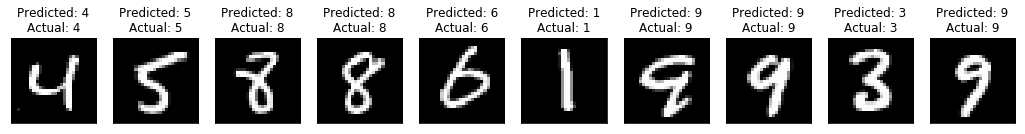

In [113]:
sample_size = 10
fig, axs = plt.subplots(ncols=sample_size)
fig.set_size_inches(18, 4)
for ax, (image, label) in zip(axs, select_k_random_elements_from(test_data, sample_size)):
    image = image.as_in_context(ctx)
    label = label.as_in_context(ctx)
    output = net(image)
    
    # Predicted label is the index where the output is maximal
    prediction = nd.argmax(output, axis=1)
    
    for image, prediction, label in zip(image, prediction, label):
        image, prediction, label = image.asnumpy(), int(prediction.asscalar()), int(label.asscalar())
        ax.imshow(image[0], cmap="gray")
        ax.set_title("Predicted: {}\nActual: {}".format(prediction, label))
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

### Visual Intuition
http://scs.ryerson.ca/~aharley/vis/conv/flat.html